# Finance Web App Project

This notebook is a Finance Web Application project where I am training a **classification model** to predict whether a given project will **succeed (1)** or **fail (0)** to end the fiscal year within the approved budget. Here I will explore the train dataset to extract the initial information, some insights from data visualization and also train a few classification models to decide wich one is the best to use.
*The output of this notebook will be a trained and tested model that will feed the Web App to be built with streamlit module.*

#### Imports

In [1]:
# Basics
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Data Preparation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# ML models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

# Hide Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Modules versions in this Notebook
%reload_ext watermark
%watermark -a "Notebook by Gustavo R Santos" --iversions

numpy   1.18.1
seaborn 0.10.0
pandas  1.0.5
Notebook by Gustavo R Santos


### 1. Data Import

In [3]:
data = pd.read_csv('finance_train.csv')

In [4]:
# First check at the data
data.head()

accountID  year      jan      feb      mar      apr      may      jun  \
0  Project01  2017     0.00   320.40  1154.69  1540.24  1554.98   975.51   
1  Project01  2018  1747.41  1301.66   954.36  1635.33  2705.71  2008.86   
2  Project01  2019   356.94  1189.87  2293.91  1586.51  1507.18  2776.40   
3  Project02  2017     0.00     0.00  1230.38   254.69  1595.24  1402.30   
4  Project02  2018     0.00     0.00     0.00  1234.44  1999.61     0.00   

       jul      aug      sep      oct      nov      dec  budget  target  
0  1238.19   964.79  1091.99  2179.70  1028.49   258.54   13000       1  
1   642.26   511.63   323.02   -97.36   322.43  1227.21   13000       0  
2  2776.42  2141.79   576.77     0.00  1441.99  1153.56   13000       0  
3  1906.25  1210.32  1361.20  1355.53  1411.68  1584.92   10000       0  
4  1879.38  2255.88  2444.51  2034.57   890.89     0.00   10000       0

### 2. Data Exploration

In [5]:
ProfileReport(data)

The Pandas Profiling report is a great resource we have in Python, as it brings us a complete statistical description of the dataset with a single line of code. So, from all of that information, we were able to extract the first insights:
+ February, April and December are the months with the higher average expense
+ The average expense per month is around $5800 USD
+ The dataset is almost balanced, with 56% of projects within budget and 44% over running the expenses
+ There are 16 variables (cols) and 91 observations (rows)
+ There is no missing data

In [6]:
# Average Expense per month
print(f'The average expense per month is: ${round(data.iloc[:,2:14].mean().mean(),2)} USD')

The average expense per month is: $5815.53 USD


In [7]:
# Data Correlation
correlation = data.corr()
correlation.style.background_gradient(cmap='coolwarm').set_precision(2)

On the correlation matrix, it is interesting to see how the months have higher correlations with the months within the same quarter, what makes much sense. The variable *year* does not bring any addition to a future model, as it is not correlated to any of the variables. Furthermore, we don't have any case where colinearity would be an issue. So let's just move on with the data exploration.

### 3. Data Visualization

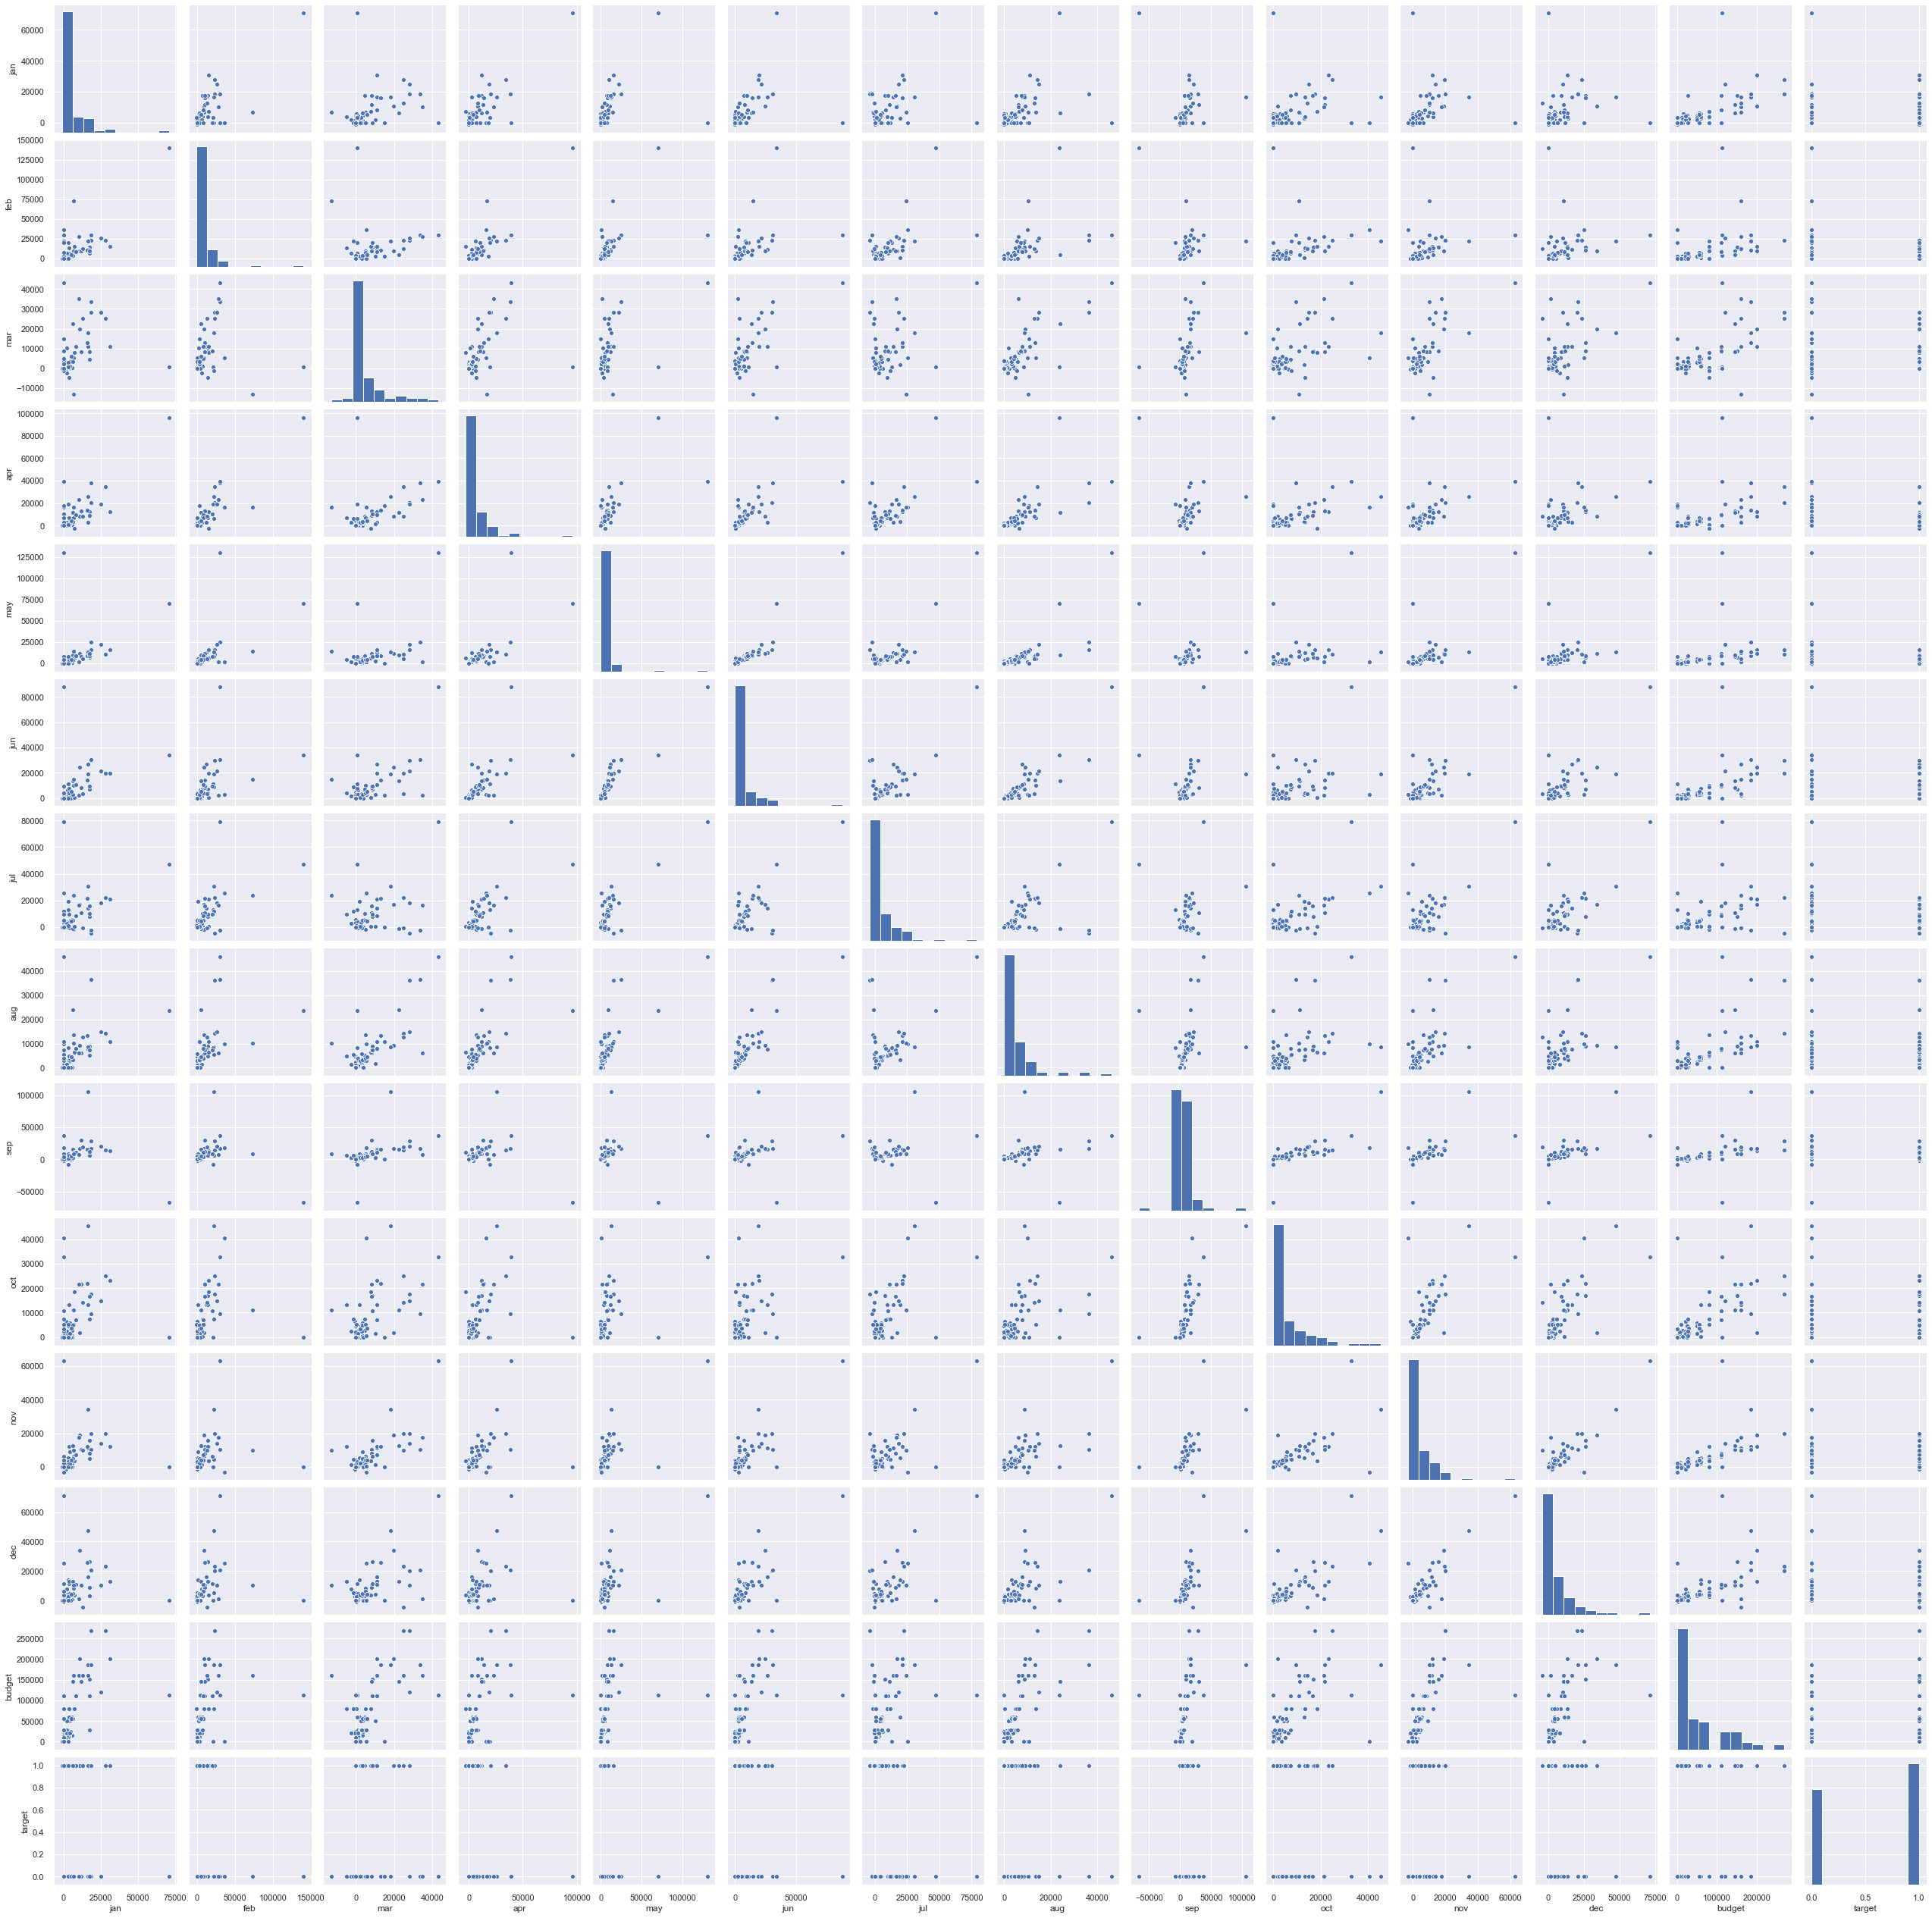

In [38]:
# Pairplot: plotting the dataset in pairs of two variables
sns.pairplot(data.drop('year', axis=1))

The graphics above show is that almost all of the expenses are below $20k USD, and they all are positively skewed, meaning concentrated in the left part of the axis, thus the bigger the amount, the less it appears.

#### 3.1 Visualizing average of expenses

In [62]:
# Let's check what are the months with higher average expenses and drop budget and target columns.
df1 = data.groupby(['year']).mean().drop(['budget','target'], axis=1).T

In [74]:
# Expense Average by month in the dataset
avg_exp = data.iloc[:,2:14].mean()

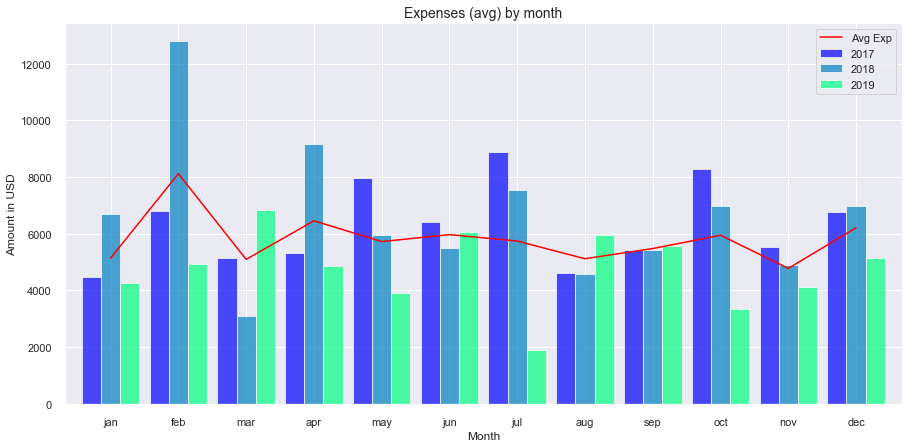

In [121]:
df1.plot(kind = 'bar', width=0.85, alpha = 0.7, figsize=(15,7), cmap='winter')
avg_exp.plot(color = 'red')
plt.title('Expenses (avg) by month', size=14)
plt.xlabel('Month')
plt.ylabel('Amount in USD')
plt.legend(['Avg Exp', 2017, 2018, 2019])
plt.show()

The graphic of expenses above can show us that the monthly expenses will have hits in **February, April, July, October and December**.

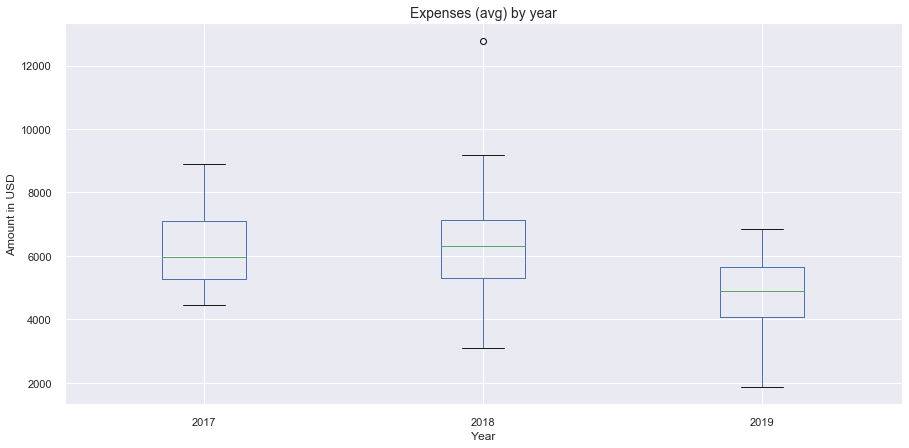

In [128]:
# Here, the same plot, but looking at it by year
df1.plot(kind = 'box', figsize=(15,7))
plt.title('Expenses (avg) by year', size=14)
plt.xlabel('Year')
plt.ylabel('Amount in USD')
plt.show()

Looking at the expenses by year, we notice that the variance of most of the values is around $2k USD, but we also see a good difference between minimum and maximum values.

#### 3.2 Visualizing the Budget

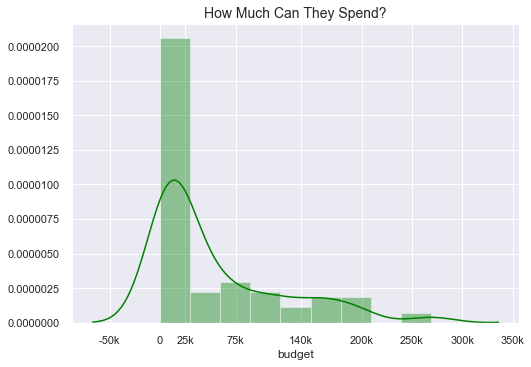

In [165]:
# The budgets are in what range of amounts?
sns.distplot(data.budget, color='green')
plt.title('How Much Can They Spend?', size=14)
plt.xticks([-50000,0,25000,75000,140000,200000,250000,300000,350000],['-50k',0,'25k','75k','140k','200k','250k','300k','350k'])
plt.show()

The project's approved budgets are **concentrated between 0-25k USD per year**.

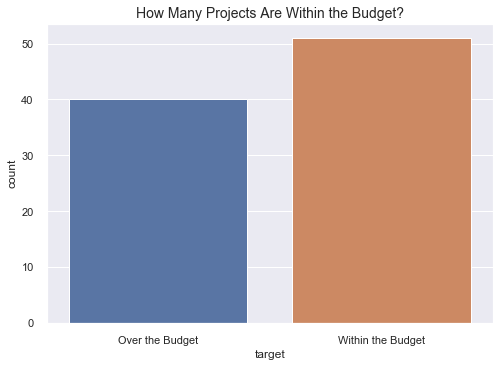

In [143]:
# How is our portfolio doing regarding being below the approved budget
sns.countplot(x = 'target', data = data)
plt.title('How Many Projects Are Within the Budget?', size=14)
plt.xticks([0,1],['Over the Budget','Within the Budget'])
plt.show()

Our dataset is almost balanced, with 56% within *vs.* 44% over.

### 4. Data Preparation

Let's continue with this notebook, now preparing the data do fit the model. As we have checked before, in the Exploration section, there are no missing data in this dataset. The only transformation I will be doing before fitting the model will be attibuting weight 2 for the months where I see expense hits in the historical data. After all, I want my model to look at those months in a different way and, based on what the user put in there as forecast, I want to be specially counted, otherwise this model would just learn how to sum the months to give me the output.

In [45]:
# Making a copy of the dataset for transformation, so we keep the original data safe
df2 = data.copy()

In [46]:
# Removing the variables 'year' and 'project ID', as those won't make difference in my model
df2.drop(['year','accountID'], axis=1, inplace=True)

In [47]:
# Attributing weight 2 for the high expense months [Feb, Apr, Jul, Oct and Dec]
for month in ['feb','apr','jul','oct','dec']:
    df2[month] = df2[month]*2

#### 4.1. Train and Test Split

In [48]:
# Separate predictors (X) from target (y)
X = df2.drop('target',axis=1)
y = df2.target

In [49]:
# Train & test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=12)

#### 4.2 Model Selection

In [50]:
# List of models to be created for comparison
models = []
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', BernoulliNB()))
models.append(('RF', RandomForestClassifier()))

# List of results and respective names of the models
results = []
names = []

In [51]:
# Loop to fit and compare the models
for name, model in models:
    kfold = KFold(n_splits = 10, random_state=12)
    cv_results = cross_val_score(model, X_train, y_train, cv = kfold, scoring = 'accuracy')
    results.append(cv_results)
    names.append(name)
    print(f'{name}: {cv_results.mean()} (std: {round(cv_results.std(),4)}%)')

LR: 0.8763888888888889 (std: 0.1119%)
DT: 0.6513888888888889 (std: 0.1582%)
NB: 0.5055555555555555 (std: 0.0982%)
RF: 0.6680555555555555 (std: 0.1901%)


The best performance above was from the **Logistic Regression**, so that is the model to be used in the continuation of this project.

#### 4.3 Logistic Regression Model

Let's do hyperparameter tuning and check the results

In [52]:
# Standardizing the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X_train)

In [53]:
# Grid Search to check best hyperparameters (WITH STANDARDIZED VALUES)
values = {'penalty':['l1', 'l2', 'elasticnet'], 'C':[-1,0,1, 2, 2.5, 3 ,5, 10], 'solver':['newton-cg', 'lbfgs', 'liblinear']}
# Instantiate the LR
model_lr1 = LogisticRegression()
# Run gridsearch
grid = GridSearchCV(model_lr1, param_grid=values).fit(X_std, y_train)
# Print best result
print(f'Accuracy: {round(grid.best_score_ *100,2)}%')
print('Best Hyperparameters: ', grid.best_estimator_)

Accuracy: 78.97%
Best Hyperparameters:  LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [54]:
# SMOTE. Rebalancing the data, so we have 50/50 distribution of the target column.
sm = SMOTE()
X_res, y_res = sm.fit_resample(X_train, y_train)

In [55]:
y_res.value_counts()

1    46
0    46
Name: target, dtype: int64

In [101]:
# Grid Search to check best hyperparameters
values = {'penalty':['l1', 'l2', 'elasticnet'], 'C':[0,1, 1.3, 1.5, 2, 2.5, 3 ,5, 10], 'solver':['newton-cg', 'lbfgs', 'liblinear']}
# Instantiate the LR
model_lr2 = LogisticRegression()
# Run gridsearch
grid = GridSearchCV(model_lr2, param_grid=values).fit(X_res, y_res)
# Print best result
print(f'Accuracy: {round(grid.best_score_ *100,2)}%')
print('Best Hyperparameters: ', grid.best_estimator_)

Accuracy: 96.84%
Best Hyperparameters:  LogisticRegression(C=1.3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [57]:
# Grid Search to check best hyperparameters
values = {'penalty':['l1', 'l2', 'elasticnet'], 'C':[-1,0,1, 2, 2.5, 3 ,5, 10], 'solver':['newton-cg', 'lbfgs', 'liblinear']}
# Instantiate the LR
model_lr3 = LogisticRegression()
# Run gridsearch
grid = GridSearchCV(model_lr3, param_grid=values).fit(X_train, y_train)
# Print best result
print(f'Accuracy: {round(grid.best_score_ *100,2)}%')
print('Best Hyperparameters: ', grid.best_estimator_)

Accuracy: 95.0%
Best Hyperparameters:  LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


We were able to reach 95.73% of accuracy in the training model with SMOTE/ not Standardized against 78% with the data Standardized. That is because the data were all concentrated and all in the same scale already.

#### 4.4 Validation of the LR model

In [102]:
# Creating the final model with balanced train dataset, not standardized.
modelLR = LogisticRegression(C=1.3, penalty='l2', solver='liblinear')
modelLR.fit(X_res, y_res)

LogisticRegression(C=1.3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [103]:
modelLR.score(X_test, y_test)

0.8

#### 4.5 Making Predictions for the Test Dataset

In [104]:
test = pd.read_csv('finance_test.csv')

In [105]:
# Attributing weight 2 for the high expense months [Feb, Apr, Jul, Oct and Dec]
for month in ['feb','apr','jul','oct','dec']:
    test[month] = test[month]*2

In [106]:
test.head()

accountID  year      jan      feb      mar      apr      may      jun  \
0  Project01  2020  3211.98  1987.10  1268.35  1543.82   771.91   964.89   
1  Project02  2020     0.00   997.02   767.29  1791.64   895.82  1119.77   
2  Project03  2020  1251.22  1654.48   413.62   104.18    52.09    65.12   
3  Project04  2020  2025.02  6403.12  7736.97  2879.28  1439.64  1799.54   
4  Project05  2020  1720.12     0.00  2895.04  2130.22  1065.11  1331.39   

       jul      aug      sep      oct      nov      dec  budget  target  
0  1543.82   964.89   771.91  1543.82   964.89  1543.82   13000       1  
1  1791.64  1119.77   895.82  1791.64  1119.77  1791.64   10000       1  
2   104.18    65.12    52.09   104.18    65.12   104.18    3000       1  
3  2879.28  1799.54  1439.64  2879.28  1799.54  2879.28   27000       1  
4  2130.22  1331.39  1065.11  2130.22  1331.39  2130.22   15000       1

In [107]:
test.shape

(30, 16)

In [108]:
X = test.drop(['accountID','year','target'], axis=1)
y = test.target

In [109]:
# Making predictions
preds = modelLR.predict(X)

In [110]:
# Calculating the accuracy
accuracy_score(y, preds)

0.9333333333333333

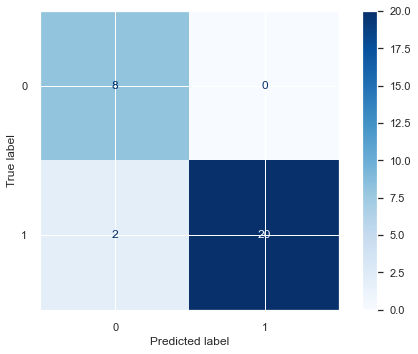

In [111]:
# Plot the confusion Matrix
plot_confusion_matrix(modelLR, X, y, cmap=plt.cm.Blues)

I am ok with an **93% precision** of my model. So this model will be saved for the second part of the project, to be embedded in a Web App. 

In [112]:
# Plotting area under the curve
y_proba = modelLR.predict_proba(X)
y_proba = y_proba[:,1]
area = roc_auc_score(y, y_proba)
print(f'Area Under the ROC Curve: {round(area,3)}')

Area Under the ROC Curve: 1.0


In [113]:
fpr, tpr, _ = roc_curve(y, y_proba)

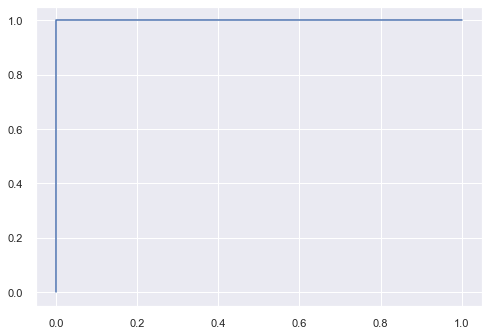

In [114]:
plt.plot(fpr, tpr)

### 5. Saving the Model for the Web App

In [115]:
import pickle

In [116]:
#Save the model
filename = 'modelFinApp.sav'
pickle.dump(modelLR, open(filename, 'wb'))